# Install libraries 


In [1]:
import sys, os
import mne, sklearn, wandb
import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from nilearn import datasets, image, masking, plotting
from nilearn.input_data import NiftiLabelsMasker


# animation part
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
# from celluloid import Camera   # it is convinient method to animate
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation



## torch libraries 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader, Subset

from pytorch_model_summary import summary


/opt/conda/envs/myenv_torch/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
%load_ext autoreload
%autoreload 2
sys.path.insert(1, os.path.realpath(os.path.pardir))

from utils import get_datasets
from utils import preproc
from utils import torch_dataset
from utils import train_utils
from utils import inference
from utils.models_arch import autoencoder_v3

# Preproc and Save dataset 
Frequence which we extract 
- Make some raw file saving in interim file
- Apply some advanced feature extraaction and normalization 
- Choose only relevant fmri roi and save it. 

## NODDI DATASET


In [3]:
from sklearn.decomposition import FastICA, PCA

In [4]:
path_to_dataset = '../data/NODDI_dataset_light/'
dataset_name = 'NODDI'
remove_confounds = True

config = dict(  
                dataset_name = dataset_name,
                new_fps=100,
                n_roi = 17,
                test_sec = 60, # in seconds.
                freqs = np.logspace(np.log10(2), np.log10(99), 16), 
                crop_start = 5
                )

In [5]:
# # for low level processing and saving 
# for patient in ['32']:

#     raw_noddi, df_eeg_noddi_raw, df_fmri_noddi_raw, labels_roi = get_datasets.download_bids_noddi_dataset(patient, path_to_dataset, 
#                                                                         remove_confounds=remove_confounds,
#                                                                         verbose=True)
#     df_eeg_noddi, df_fmri_noddi, fps = get_datasets.interpolate_df_eeg_fmri(df_eeg_noddi_raw, df_fmri_noddi_raw)
#     config['fps'] = fps
#     print('Original FPS', config['fps']) 
    
#     # delete time columns. 
#     # reshape [time, ch] -> [ch, time]
#     eeg_np = df_eeg_noddi.drop(['time'], axis=1).to_numpy().T
#     fmri_np = df_fmri_noddi.drop(['time'], axis=1).to_numpy().T
    
#     ## EEG preproc.
#     pca = PCA(n_components=eeg_np.shape[0])
#     ica = FastICA(n_components=eeg_np.shape[0], random_state=0)
    
    
#     eeg_np = preproc.low_level_preproc_eeg(eeg_np, fps)
        
#     eeg_white = pca.fit_transform(eeg_np.T) # time, n_electrodes
#     stds = np.std(eeg_white, axis = 0, keepdims=True)
#     eeg_white /= stds

#     eeg_ica_comp = ica.fit_transform(eeg_white)
#     eeg_ica_comp_original = eeg_ica_comp.copy()
#     eeg_ica_comp[:, 41] = 0

#     eeg_remove_eog = ica.inverse_transform(eeg_ica_comp)
#     eeg_remove_eog *= stds
#     eeg_remove_eog = pca.inverse_transform(eeg_remove_eog).T
    
#     np.savez(f'../data/interim/{config["dataset_name"]}/{patient}_{config["fps"]}_filtered_data', 
#              eeg=eeg_remove_eog, fmri=fmri_np)

# features extraction.
for patient in ['32']:
    config["fps"] = 250
    path = f'../data/interim/{config["dataset_name"]}/{patient}_{config["fps"]}_filtered_data' + '.npz'
    data = np.load(path)
    
    eeg_np, fmri_np = data['eeg'], data['fmri']
    
    # crop and normalize
    train_crop = config['crop_start']*config['fps']
    print('Crop starting regions:', train_crop)
    
    eeg_np, fmri_np = eeg_np[..., train_crop:], fmri_np[..., train_crop:]
    
    # normalize 
    eeg_np = eeg_np / np.std(eeg_np)
    fmri_np, fmri_means_stds = preproc.normalize_data(fmri_np)
    
    
    # features
    eeg_wavelets, freqs = preproc.compute_wavelet(eeg_np, sf=config['fps'], freqs=config['freqs'])
    eeg_wavelets = np.log10(eeg_wavelets + 1e-6)
    
    dataset_train, dataset_test = preproc.divide_train_test(eeg_wavelets, fmri_np,
                                                            fps=config['fps'], 
                                                            test_sec=config['test_sec'])


    # # downsample if needed 
    ds_factor = config['fps']/config['new_fps']

    x_train, y_train = preproc.downsample_dataset(dataset_train, factor = ds_factor)
    x_test, y_test = preproc.downsample_dataset(dataset_test, factor = ds_factor)


    print('Downsample. Size of train dataset:', x_train.shape, y_train.shape)
    print('Size of test dataset:', x_test.shape, y_test.shape)
    
    np.savez(f'../data/processed/{config["dataset_name"]}/{patient}_{config["new_fps"]}_hz_17_roi_2_99_freqs', 
             x_train=x_train, y_train=y_train,
             x_test=x_test, y_test=y_test)





Crop starting regions: 1250
Size of train dataset: eeg (63, 16, 145210) | fmri (17, 145210)
Size of test dataset: eeg (63, 16, 15000) | fmri (17, 15000)
Downsample. Size of train dataset: (63, 16, 58084) (17, 58084)
Size of test dataset: (63, 16, 6000) (17, 6000)


In [7]:
import json 
with open("../data/interim/labels_roi_17.json", 'r') as f:
    labels_roi_17 = json.load(f)

with open("../data/processed/labels_roi_6.json", 'r') as f:
    labels_roi_6 = json.load(f)
    
    


In [9]:
for patient in ['32']:
    data = np.load(f'../data/processed/{config["dataset_name"]}/{patient}_{config["new_fps"]}_hz_17_roi_2_99_freqs.npz')
    x_train, y_train = data['x_train'], data['y_train']
    x_test, y_test = data['x_test'], data['y_test']
    
    df = pd.DataFrame(data = y_train.T, columns=labels_roi_17)
    df_filter = df[labels_roi_6]
    y_train = df_filter.to_numpy().T
    
    df = pd.DataFrame(data = y_test.T, columns=labels_roi_17)
    df_filter = df[labels_roi_6]
    y_test = df_filter.to_numpy().T
    
    np.savez(f'../data/processed/{config["dataset_name"]}/{patient}_{config["new_fps"]}_hz_6_roi_2_99_freqs', 
             x_train=x_train, y_train=y_train,
             x_test=x_test, y_test=y_test)

In [62]:
labels_roi_17

['Left Lateral Ventricle',
 'Left Thalamus',
 'Left Caudate',
 'Left Putamen',
 'Left Pallidum',
 'Brain-Stem',
 'Left Hippocampus',
 'Left Amygdala',
 'Left Accumbens',
 'Right Lateral Ventricle',
 'Right Thalamus',
 'Right Caudate',
 'Right Putamen',
 'Right Pallidum',
 'Right Hippocampus',
 'Right Amygdala',
 'Right Accumbens']

In [59]:
with open("../data/processed/labels_roi_6.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable
    json.dump(labels_roi_6, f, indent=2) 

### Visualization. 

IndexError: index 63 is out of bounds for axis 1 with size 63

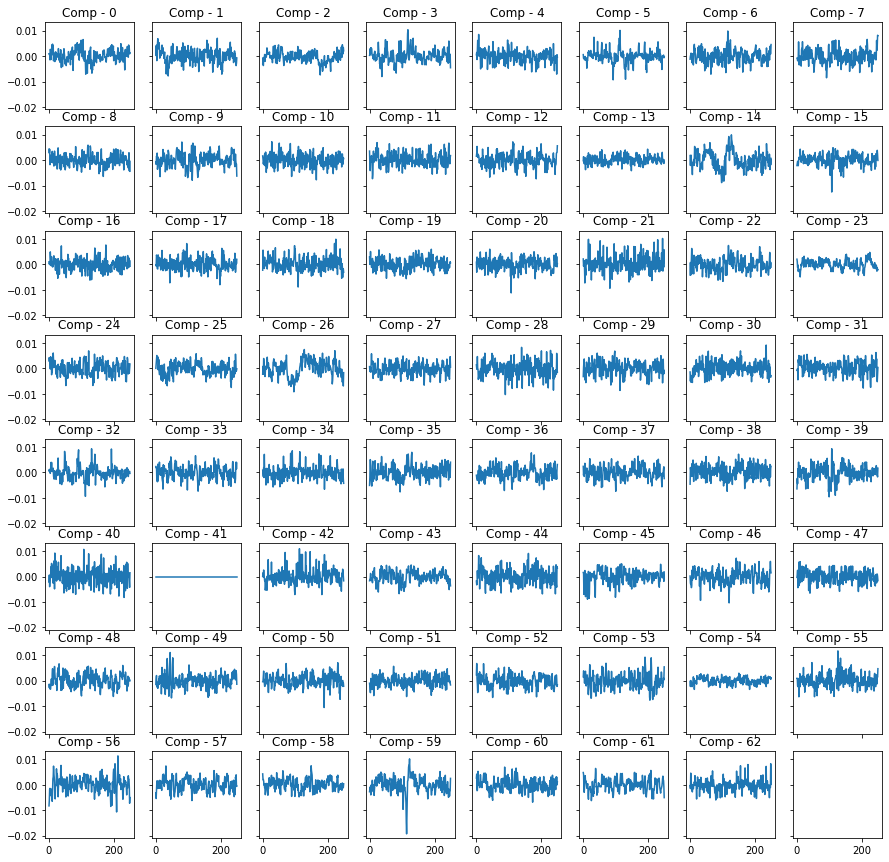

In [8]:
fig, ax = plt.subplots(8, 8, figsize = (15, 15), sharey=True, sharex=True) 
for i, axi in enumerate(ax.flat):
    axi.plot(eeg_ica_comp[9000:10000:4, i])
    axi.set_title('Comp - '+ str(i))

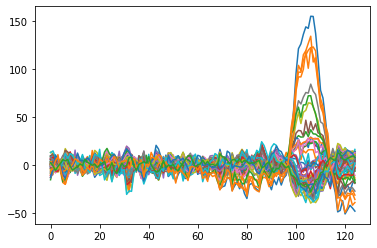

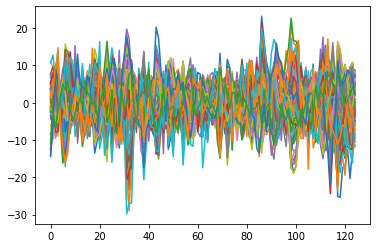

In [9]:
_ = plt.plot(eeg_np[:, 9000:9500:4].T)
plt.show()
_ = plt.plot(eeg_remove_eog[:, 9000:9500:4].T)


## CWL DATASET

In [13]:
path_to_dataset = '../data/eyes_open_closed_dataset/'
dataset_name = 'CWL'
remove_confounds = True

config = dict(  
                dataset_name = dataset_name,
                new_fps=100,
                n_roi = 17,
                test_sec = 60, # in seconds.
                crop_start = 5,

                freqs = np.logspace(np.log10(2), np.log10(99), 16), 
                )



In [7]:
# for patient in ['trio1', 'trio2', 'trio3', 'trio4']:

#     df_eeg_cwl_raw, df_fmri_cwl_raw, labels_roi = get_datasets.download_cwl_dataset(patient, path_to_dataset, 
#                                                                         remove_confounds=remove_confounds,
#                                                                         verbose=True)
#     df_eeg_cwl, df_fmri_cwl, fps = get_datasets.interpolate_df_eeg_fmri(df_eeg_cwl_raw, df_fmri_cwl_raw)
#     config['fps'] = fps
#     print('Original FPS', config['fps']) 
    
#     # delete time columns. 
#     # reshape [time, ch] -> [ch, time]
#     eeg_np = df_eeg_cwl.drop(['time'], axis=1).to_numpy().T
#     fmri_np = df_fmri_cwl.drop(['time'], axis=1).to_numpy().T
    
    
#     eeg_np = preproc.low_level_preproc_eeg(eeg_np, fps)
    
#     np.savez(f'../data/preproc/{config["dataset_name"]}/{patient}_{config["fps"]}_filtered_data', 
#              eeg=eeg_np, fmri=fmri_np)

    

for patient in ['trio1', 'trio2', 'trio3', 'trio4']:
    config["fps"] = 1000
    path = f'../data/interim/{config["dataset_name"]}/{patient}_{config["fps"]}_filtered_data' + '.npz'
    data = np.load(path)
    
    eeg_np, fmri_np = data['eeg'], data['fmri']
    
    # crop and normalize
    train_crop = config['crop_start']*config['fps']
    print('Crop starting regions:', train_crop)
    
    eeg_np, fmri_np = eeg_np[..., train_crop:], fmri_np[..., train_crop:]
    
    # normalize 
    eeg_np = eeg_np / np.std(eeg_np)
    fmri_np, fmri_means_stds = preproc.normalize_data(fmri_np)
    
    
    # features
    eeg_wavelets, freqs = preproc.compute_wavelet(eeg_np, sf=config['fps'], freqs=config['freqs'])
    eeg_wavelets = np.log10(eeg_wavelets + 1e-6)
    
    dataset_train, dataset_test = preproc.divide_train_test(eeg_wavelets, fmri_np,
                                                            fps=config['fps'], 
                                                            test_sec=config['test_sec'])


    # # downsample if needed 
    ds_factor = config['fps']/config['new_fps']

    x_train, y_train = preproc.downsample_dataset(dataset_train, factor = ds_factor)
    x_test, y_test = preproc.downsample_dataset(dataset_test, factor = ds_factor)


    print('Downsample. Size of train dataset:', x_train.shape, y_train.shape)
    print('Size of test dataset:', x_test.shape, y_test.shape)
    
    np.savez(f'../data/processed/{config["dataset_name"]}/{patient}_{config["new_fps"]}_hz_17_roi_2_99_freqs', 
             x_train=x_train, y_train=y_train,
             x_test=x_test, y_test=y_test)





    
    




Crop starting regions: 5000
Size of train dataset: eeg (30, 16, 211900) | fmri (17, 211900)
Size of test dataset: eeg (30, 16, 60000) | fmri (17, 60000)
Downsample. Size of train dataset: (30, 16, 21190) (17, 21190)
Size of test dataset: (30, 16, 6000) (17, 6000)
Crop starting regions: 5000
Size of train dataset: eeg (30, 16, 215800) | fmri (17, 215800)
Size of test dataset: eeg (30, 16, 60000) | fmri (17, 60000)
Downsample. Size of train dataset: (30, 16, 21580) (17, 21580)
Size of test dataset: (30, 16, 6000) (17, 6000)
Crop starting regions: 5000
Size of train dataset: eeg (30, 16, 213850) | fmri (17, 213850)
Size of test dataset: eeg (30, 16, 60000) | fmri (17, 60000)
Downsample. Size of train dataset: (30, 16, 21385) (17, 21385)
Size of test dataset: (30, 16, 6000) (17, 6000)
Crop starting regions: 5000
Size of train dataset: eeg (30, 16, 223600) | fmri (17, 223600)
Size of test dataset: eeg (30, 16, 60000) | fmri (17, 60000)
Downsample. Size of train dataset: (30, 16, 22360) (17,

In [14]:
for patient in ['trio1', 'trio2', 'trio3', 'trio4']:
    data = np.load(f'../data/processed/{config["dataset_name"]}/{patient}_{config["new_fps"]}_hz_17_roi_2_99_freqs.npz')
    x_train, y_train = data['x_train'], data['y_train']
    x_test, y_test = data['x_test'], data['y_test']
    
    df = pd.DataFrame(data = y_train.T, columns=labels_roi_17)
    df_filter = df[labels_roi_6]
    y_train = df_filter.to_numpy().T
    
    df = pd.DataFrame(data = y_test.T, columns=labels_roi_17)
    df_filter = df[labels_roi_6]
    y_test = df_filter.to_numpy().T
    
    np.savez(f'../data/processed/{config["dataset_name"]}/{patient}_{config["new_fps"]}_hz_6_roi_2_99_freqs', 
             x_train=x_train, y_train=y_train,
             x_test=x_test, y_test=y_test)

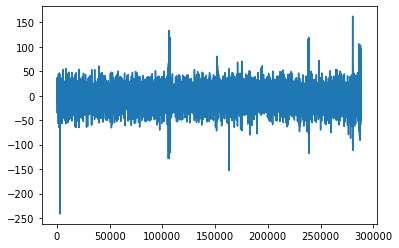

In [24]:
plt.plot(eeg_np.T[:, 0])

<AxesSubplot:xlabel='time'>

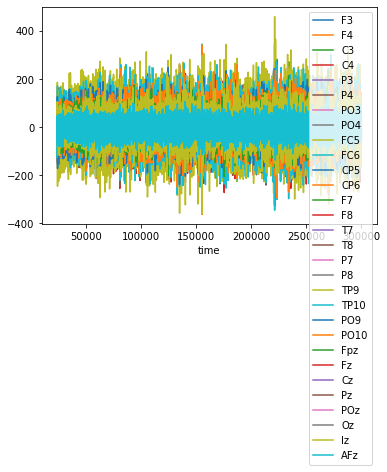

In [179]:
df_eeg_cwl.plot(x = 'time', )

In [189]:
eeg = train_dataset_prep[0]

from sklearn.decomposition import FastICA, PCA
pca = PCA(n_components=30)

ica = FastICA(n_components=30, random_state=0)

# ica.fit(eeg.T)


X_white = pca.fit_transform(eeg.T)
stds = np.std(X_white, axis =0, keepdims=True)
X_white = X_white/ stds

X_ica_comp = ica.fit_transform(X_white)
X_ica_comp_original = X_ica_comp.copy()
X_ica_comp[:, 1] = 0

X_remove_ica = ica.inverse_transform(X_ica_comp)
X_remove_ica *= stds
X_remove_ica = pca.inverse_transform(X_remove_ica).T

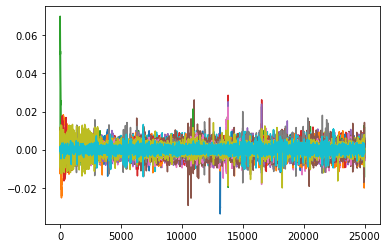

In [190]:
plt.plot(X_ica_comp[:100000:4, :])

## Save labels roi 

In [11]:
import json

,Left Thalamus,Left Caudate,Left Putamen,Right Thalamus,Right Caudate,Right Putamen


In [33]:
df.columns.str.contains(pattern, case=False)

array([False, False,  True,  True, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False])

In [18]:
pd.Series(labels_roi).str.find('Caudate')


0    -1
1    -1
2     5
3    -1
4    -1
5    -1
6    -1
7    -1
8    -1
9    -1
10   -1
11    6
12   -1
13   -1
14   -1
15   -1
16   -1
dtype: int64

In [ ]:
# saving 
import json

with open("..data/preproc/CWL/labels_roi.json", 'w') as f:
    # indent=2 is not needed but makes the file human-readable
    json.dump(labels_roi, f, indent=2) 




# Visualization 

In [9]:
trio_cwl = np.load('../data/preproc/CWL/trio1_100_hz_17_roi_1_99_freqs.npz')

In [10]:
trio_nod = np.load('../data/preproc/NODDI/32_100_hz_17_roi_1_99_freqs.npz')

(array([1.44640e+04, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        2.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        5.00000e+00, 5.00000e+00, 5.00000e+00, 3.00000e+00, 1.00000e+00,
        7.00000e+00, 8.00000e+00, 8.00000e+00, 7.00000e+00, 1.10000e+01,
        1.40000e+01, 1.70000e+01, 1.90000e+01, 1.80000e+01, 2.60000e+01,
        3.50000e+01, 3.10000e+01, 4.00000e+01, 5.50000e+01, 7.90000e+01,
        9.10000e+01, 1.02000e+02, 1.29000e+02, 2.13000e+02, 2.29000e+02,
        2.39000e+02, 3.32000e+02, 4.08000e+02, 5.25000e+02, 6.28000e+02,
        8.16000e+02, 1.04500e+03, 1.33700e+03, 1.84600e+03, 2.23300e+03,
        2.74300e+03, 3.60500e+03, 4.30100e+03, 5.68600e+03, 6.94000e+03,
        8.64600e+03, 1.05990e+04, 1.31310e+04, 1.60820e+04, 1.95150e+04,
        2.38230e+04, 2.87840e+04, 3.46270e+04, 4.15710e+04, 4.90260e+04,
        5.81580e+04, 6.83820e+04, 8.02260e+04, 9.21780e+04, 1.04813e+05,
        1.18236e+05, 1.31744e+05, 1.45400e+05, 1.56

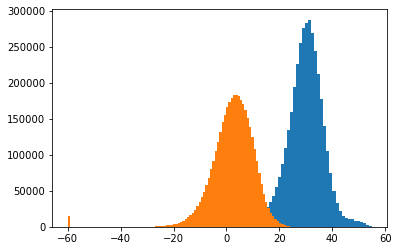

In [18]:
plt.hist(trio_['x_train'][:, 0, :].reshape(-1), bins =100)
plt.hist(trio_['x_train'][:, -1, :].reshape(-1), bins =100)

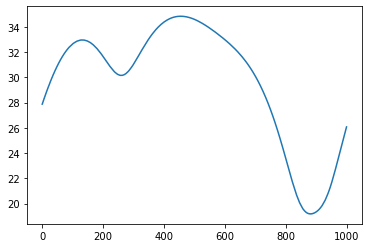

In [19]:
plt.plot(trio_['x_test'][20, 0, :1000])

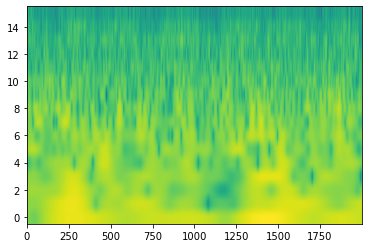

In [22]:
plt.imshow(trio_['x_test'][30, :, :2000], aspect='auto', origin = 'lower')

In [26]:
trio_['y_train'].shape

(17, 58584)

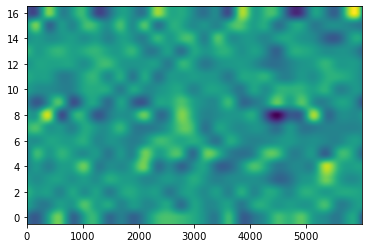

In [23]:
plt.imshow(trio_['y_test'], aspect='auto', origin = 'lower')

In [18]:
# np.savez(f'../data/preproc/NODDI/{patient}_NODDI_250_hz_17_roi_1_49_freqs', 
#          x_train=train_dataset_prep[0], y_train=train_dataset_prep[1],
#          x_test=test_dataset_prep[0], y_test=test_dataset_prep[1])


# Confounds 

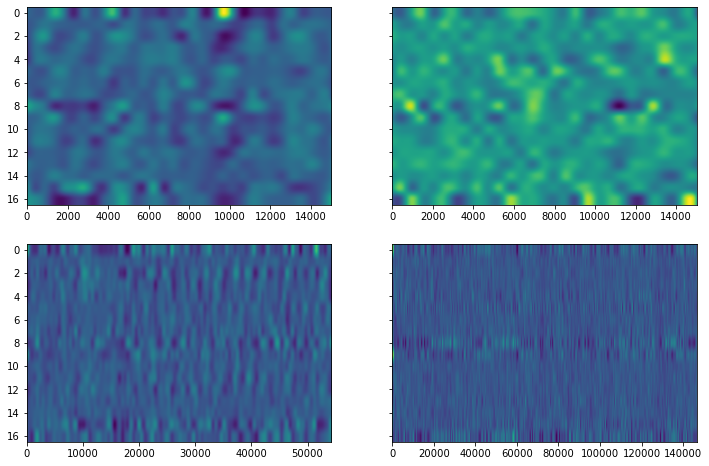

In [10]:
fmri_cwl_train, fmri_cwl_test = fmri_cwl[:, :-60*250],  fmri_cwl[:, -60*250:]
fmri_noddi_train, fmri_noddi_test = fmri_noddi[:, :-60*250],  fmri_noddi[:, -60*250:] 

fig, ax = plt.subplots(2, 2, figsize = (12, 8), sharey=True)
ax[0, 0].imshow(fmri_cwl_test, aspect = 'auto')
ax[0, 1].imshow(fmri_noddi_test, aspect = 'auto')
ax[1, 0].imshow(fmri_cwl_train, aspect = 'auto')
ax[1, 1].imshow(fmri_noddi_train, aspect = 'auto')


from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')


correlation_matrix = correlation_measure.fit_transform([fmri_cwl_train.T])[0]
np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels_roi,
                     vmax=1, vmin=-1, reorder=False)

print('CWL test')
print('Train mean corr ', np.mean(np.abs(correlation_matrix)))


correlation_matrix = correlation_measure.fit_transform([fmri_cwl_test.T])[0]
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels_roi,
                     vmax=1, vmin=-1, reorder=False)
print('Test mean corr ', np.mean(np.abs(correlation_matrix)))




from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')


correlation_matrix = correlation_measure.fit_transform([fmri_noddi_train.T])[0]
np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels_roi,
                     vmax=1, vmin=-1, reorder=False)

print('CWL test')
print('Train mean corr ', np.mean(np.abs(correlation_matrix)))


correlation_matrix = correlation_measure.fit_transform([fmri_noddi_test.T])[0]
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels_roi,
                     vmax=1, vmin=-1, reorder=False)
print('Test mean corr ', np.mean(np.abs(correlation_matrix)))


['Left Cerebral White Matter', 'Left Cerebral Cortex ', 'Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Cerebral White Matter', 'Right Cerebral Cortex ', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens']


In [51]:
np.savez('dataset_NODDI_250_hz', 
         x_train=train_dataset_prep[0], y_train=train_dataset_prep[1],
         x_test=test_dataset_prep[0], y_test=test_dataset_prep[1])


# 